# Calculus

## Gradients
Lets say $f: \mathbb{R}^n \rightarrow \mathbb{R}$ as each partial derivitive well defined at $x_0 \in \mathbb{R}^n$, then $$\nabla f(x_0) = \left(\frac{\partial }{\partial x_1}f(x_0),...,\frac{\partial }{\partial x_n}f(x_0)\right)$$. 

# Dimensionality Reduction

# Softmax Regression

## Data

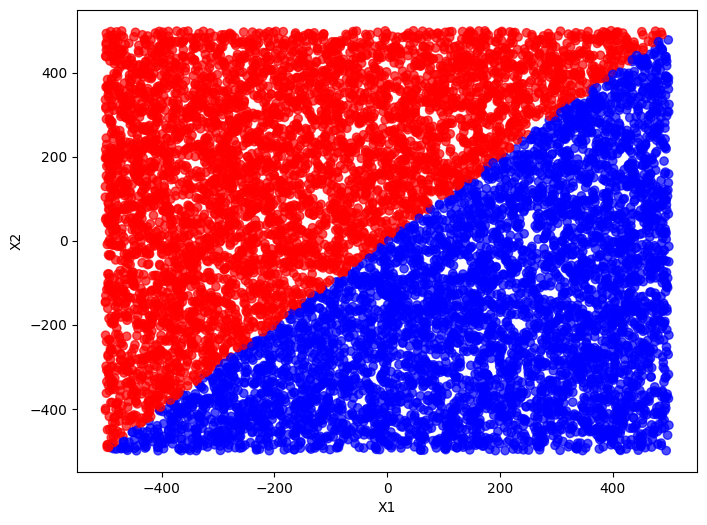

In [51]:
import numpy as np
import matplotlib.pyplot as plt

m = 1
b =  0
num_points = 10000
X = np.random.rand(num_points,2) * 1000 - 500 
y_hyperplane = m * ((X[:, 0])) + b
labels = np.zeros(shape= [num_points,2])
for i in range(num_points):
    labels[i][(X[:, 1] > y_hyperplane).astype(int)[i]] = 1
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(labels,axis=1), cmap='bwr', alpha=0.7)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()
Labels = [np.array(inner_list) for inner_list in labels]

## Classifier

`Forward Function`: 
$$\sigma_i(x) = \frac{\exp({w^{T}_ix + b})}{\sum_k^K \exp(w^{T}_kx + b) }$$
- $w_i \in \mathbb{R}^{parameters}$
- $x \in \mathbb{R}^{parameters}$
- $\sigma(x) \in \mathbb{R}^{classes}$

`CELoss`: $$-y\cdot \log(\sigma(x))$$ where $y$ is the target one-hot encoding. $\forall i \in [1,n]$, $w_i$ represents the weights for each class. In the sample above we have 2 classes

### Computing gradients 
Ideally, we want our losses to be to zero. To do that we need to find $W$ where our function is at its minimum, and to do that we need to take the derivative of the function in respect to $w$ and solve for $0$. This solution here isn't closed form (our solution isn't bounded).
Considering that $$CELoss = -\sum^K_i y_i \log(\sigma(x))$$ We define our gradient's partial derivatives as, $$\frac{\partial \text{CELoss}}{\partial W_j} = \sum^K_i\frac{\partial \text{CELoss}} {\partial \sigma_i(x)}\frac{ \partial \sigma_i(x)}{\partial z_i} \frac{\partial z_i}{W_j} $$ where $z = w^Tx$.\
So, I can go ahead and do $$\sum^K_i\frac{\partial \text{CELoss}}{\partial \sigma_i(X)} = -\sum^K_i\left( y_i \frac{1}{\sigma_i(x)} \frac{ \partial \sigma_i(x)}{\partial z_i} \frac{\partial z_i}{W_j}\right)$$
I'll skip the long part right now and say that $\frac{\partial z_i}{\partial W_j} = x$ if we concatenate the bias vector into the weight matrix as it's first element


I'll go ahead and compute  $\frac{\partial \sigma(x)_i}{\partial z_i}$
$$\frac{\partial \sigma(x)_i}{\partial z_i} = \frac{\partial}{\partial{z_i}}\frac{\exp{(z_i)}}{\sum^K_k \exp(z_k)}$$

If $i = j$, $$\frac{\partial \sigma(x)_i}{\partial z_i}= \frac{\exp{z_i}\left(\sum^K_k \exp(z_k)\right) - \exp(z_i)^2}{\left(\sum^K_k \exp(z_k)\right)^2} = \sigma_i(x)(1-\sigma_i(x))$$

if $i \neq j$, $$ \frac{\partial \sigma(x)_i}{\partial z_i} = \frac{- \exp{(z_j)\exp(z_i)}}{\left(\sum^K_k \exp(z_k)\right)^2} = -\sigma_i(x)\sigma_j(x)$$

Computing the whole thing, in the case of $i = j$ $$-\sum^K_{i=j} \left(y_i \cdot \frac{1}{\sigma_i(x)} \cdot \sigma_i(x)(1-\sigma_i(x))\cdot x\right) = -\sum^K_{i=j} y_i(1-\sigma_i(x))\cdot x$$For $i \neq j$, $$\sum^K_{i\neq j} y_i \sigma_j(x) x$$


$$\frac{\partial CELoss}{\partial W_j} = -\sum^K_{i=j} y_i(1-\sigma_i(x))\cdot x + \sum^K_{i\neq j} y_i \sigma_j(x) x$$


$$\frac{\partial CELoss}{\partial W_j} = -y_j x + y_j\sigma_j(x) \cdot x + \sum^K_{i\neq j} y_1 \cdot \sigma_j{(x)}\cdot x$$

$y_1$ is when $y_i = 1$. All other cases are equal to $0$

$$\frac{\partial CELoss}{\partial W_j} = -y_j x + y_j\sigma_j(x) \cdot x + \sigma_j{(x)}\cdot x$$

Since $y_1 \neq y_j$, this equation is effectively $$\frac{\partial CELoss}{\partial W_j} = -y_ix + \sigma_j(x)\cdot x$$

`backwards`:$$(\sigma_j(x)-y_j)\cdot x$$

**Keep in mind** that $\frac{\partial z}{\partial W}$ is only $x$ when we have one linear layer like $w^Tx + b$. When dealing with larger models like neural networks this will be different.

In [52]:
class SoftMaxClassifier:
    def __init__(self,input:int,output:int, bias=True):
        if bias: input+=1
        self.input = input
        self.output = output
        self.bias = bias
        self.W = np.random.random(size=[input,output])
        self.W_grad = np.zeros(shape=[input,output])
        
    def forward(self,x:np.array):
        if self.bias: x = np.concat([np.ones((1,)),x])
        lin = (self.W).T @ x
        K = self.output
        score = np.zeros(shape=[K,1])
        for i in range(K):
            numerator = np.exp(self.W.T[i] @ x)
            denominator = 0
            for j in range(K):
                denominator+=np.exp(self.W.T[j] @ x)
            score[i] = numerator/denominator
        return score
            
    def CELoss(self,x:np.array,sigma:np.array,y:np.array):
        if self.bias:x = np.concat([np.ones((1,)),x])
        loss = -(y @ np.log(sigma))
        grad = np.zeros(shape=[self.output,self.input])
        K = self.output
        # w ∈ ℝ^(3x2)
        for j in range(K):
            grad[j] = (sigma[j] - y[j]) * x
            # print(grad)
        self.W_grad = grad.T
        return loss
   
class SGD:
    def __init__(self,model,learning_rate):
        self.model= model
        self.lr=learning_rate
    def step(self):
        self.model.W = self.model.W - self.lr * self.model.W_grad




### Training

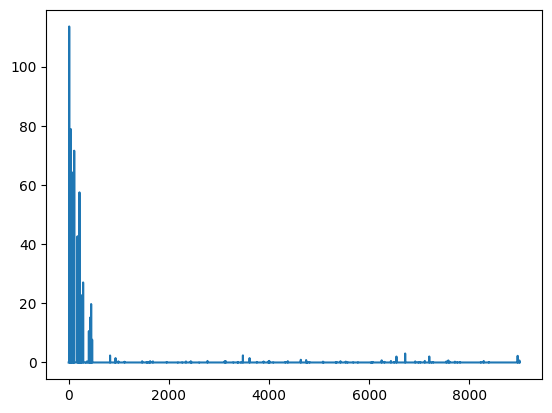

In [61]:
model = SoftMaxClassifier(2,2)
Optimizer = SGD(model,0.00001)
loss_arr = []
for i in range(9000):
    x = X[i]
    y = Labels[i]
    sigma = model.forward(x)
    loss = model.CELoss(x,sigma,y)
    loss_arr.append(loss)
    Optimizer.step()

plt.plot(loss_arr)
plt.show()


### Testing

In [62]:
acc = 0
for i in range(9000,10000):
    x = X[i]
    y = Labels[i]
    sigma = model.forward(x)    
    score = np.zeros_like(sigma)
    score[np.argmax(sigma,axis = 0)]=1
    acc +=score.T @ y
np.set_printoptions(2)
print(f"accuracy: {(acc[0]/1000)*100}%")



accuracy: 99.8%


# SVM

We'll go ahead and use the same data for this, excepet now our label set shall change to -1 and 1 Lets assume that there exists a hyperplane that perfectly seperates our data(it does). 

### Geometric margin
Lets say we have a classifier $y_i(w\cdot x + b) \geq 0$, then at point $x$ the distance euclidean distance to the hyperplane is calculated as
$$m(x) = \frac{|w \cdot x + b|}{||w||_2}$$

The goal of the SVM is to maximize this distance for our sample set.

## Linearly Seperable Problem 


You want to maximize the euclidean distance between the classifier and the sample input thats the closest. $$p = \max_{w: y_i(w\cdot x_i) \geq 0} \min_{i} m(x_i)$$ in the sample $S = \{x_1,...,x_n\}$. Since the sample is linearly seperable, $y_i(w\cdot x_i)$ is positive, $$p = \frac{1}{||w||_2}$$ **A lot of literature will write $||w||$. In this case they would be referring to $L2$ norm, which is $||w||_2$, which is equal to $\sqrt{\sum_i w_i^2 }$**. 

Now, if we want to maximize $p$, that also means we want to minimize $||w||_2$. Now, intuitivelely we have to realize that our optimal($wx + b = 0$) hyperplane should be surrounded by 2 hyperplanes ($wx + b_1 = -1$) and ($wx + b_2 = 1$), making a street - an analogy you'll see frequently in literature. 

And so, we have our problem: $$\min_2 ||w||_2^2$$ $$\text{Subject to } 1 - y_i(wx + b) \leq 0 \implies \text{classifies correctly}$$ squareing $w$ adds more penalty than abs. 

#### Lagrangian Multipliers
We want to convert a constrained problem into a form where the derivitive test(finding critical points) of an unconstrained problem can still be applied. To find the max or min of a function with the constraints, we want to find all the points of $L$ such that the derivative - all partial derivatives - are equal to $0$. The solution to this problem is a saddle point
$$L(x, \lambda) = f(x) + \lambda \cdot g(x)$$


#### Support Vectors
The Lagrangian is defined for all $w \in \mathbb{R}^N$, $b \in \mathbb{R}$, and $\alpha \in \mathbb{R}^m_+$
$$L(w,b,\alpha) = \frac{1}{2} ||w||^2 - \sum^m_{i=1} \alpha_i \left[ y_i(wx_i + b) - 1 \right]$$




$$\frac{\partial L}{\partial w} = ||w|| - \sum^m_i \alpha_i y_i x_i = 0 \implies w = \sum_i^m \alpha_i y_i x_i$$
$$\frac{\partial L}{\partial b} =  - \sum^m_i \alpha_i y_i = 0 \implies 0 = \sum_i^m \alpha_i y_i $$

Plugging in what we know about $w$ and $b$, $$L(w,b,\alpha) = \frac{1}{2} \left( \sum_i^m \alpha_i y_i x_i \right)^2 - \sum^m_{i=1} \alpha_iy_ix_i \left[\left(\left(\sum_i^m \alpha_i y_i x_i\right) + b \right) - 1 \right]$$


$$L(w,b,\alpha) = \sum_i \alpha_i - \frac{1}{2} \sum_i \sum_j \alpha_i \alpha_j y_i y_j x_i x_j $$
 Now we gotta solve this with the SMO quadratcic programming algorithm.

## SMO

### KKT Conditions
Lets say we want to minimize $f(x)


## Non-seperable case

In [ ]:
class SVM:
    def __init__(self, input_size, output_size,bias = True):
        self.input_size = input_size
        self.output_size = output_size
        self.bias=bias
        if bias: W = np.random.rand([input_size+1])
        else: W= np.random.rand([input_size])
        self.W = W
    def forward(self,x):
        if self.bias: x = np.concat([np.ones((1,)),x])
        return np.sign(self.W@x)
    
    def hinge_loss(self,forward_pass,y):
        loss =  np.max(0,y*forward_pass - 1)
        

        

# Trees

# Neural Networks
- Linear
- Convolutional
- Reccurrent

## Linear Layers

Lets say we have an input vector $x \in \mathbb{R} ^{n \times 1}$. If we were doing linear regression, like in the softmax problem, we've familiarlized ourselves with weights being in the space $w \in \mathbb{R}^{2 \times n}$(since we had 2 classes). But maybe this vector isn't complex enough. Maybe we can make it even better. 


Lets define our linear layer as a weight matrix ${W} \in \mathbb{R}^{m \times n}$. Like before, where $z = w^Tx + b$, we're still doing the same thing, except $w^Tx + b \in \mathbb{R}^{m \times 1}$ 

We then take the output of that result and pass it into another layer, like the $w$ matrix in the softmax where we end up with a $\mathbb{R}^{1 \times 2}$ vector